In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models

In [34]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


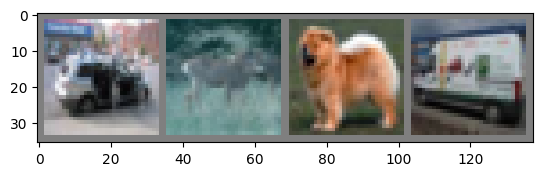

car   deer  dog   truck


In [35]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [91]:
class DinoHead(torch.nn.Module):

    def __init__(self, in_dim=2048, out_dim=60000, hidden_dim=4096, bottleneck_dim=256):
        super().__init__()

        self.mlp = torch.nn.Sequential(*[
            torch.nn.Linear(in_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, bottleneck_dim)
        ])
        self.last_layer = torch.nn.Linear(bottleneck_dim, out_dim, bias=False)

    def forward(self, x):
        x = self.mlp(x)
        return x

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dino_model = torch.hub.load_state_dict_from_url("https://dl.fbaipublicfiles.com/dino/dino_resnet50_pretrain/dino_resnet50_pretrain_full_checkpoint.pth", map_location=device)['teacher']
dino_model = {k.replace("backbone.", ""): v for k, v in dino_model.items()}

In [92]:
resnet50 = models.resnet50()
resnet50.fc = torch.nn.Identity()
resnet50.head = DinoHead()
resnet50.load_state_dict(dino_model, strict=True)
resnet50.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

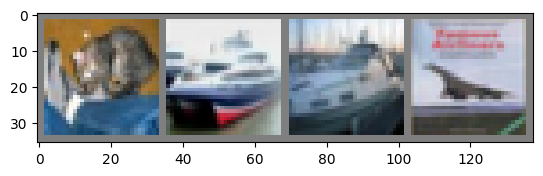

GroundTruth:  cat   ship  ship  plane


In [5]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [93]:
backbone = resnet50(images)
head = resnet50.head(backbone)
output = resnet50.head.last_layer(head)
output.shape

torch.Size([4, 60000])

In [90]:
backbone.shape

torch.Size([4, 2048])